In [72]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [73]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [74]:
s = ctl.TransferFunction.s
G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0) * (5.1783*s + 23.3272)/(0.0352*s + 1.0)

G_bkp = G
G

TransferFunction(array([0.1294575, 0.58318  ]), array([ 0.00547732,  0.12783515, -0.75373795,  1.        ]))

polos:  (-28.409+0j) (2.535+0j) (2.535+0j)
zeros:  (-4.505+0j)


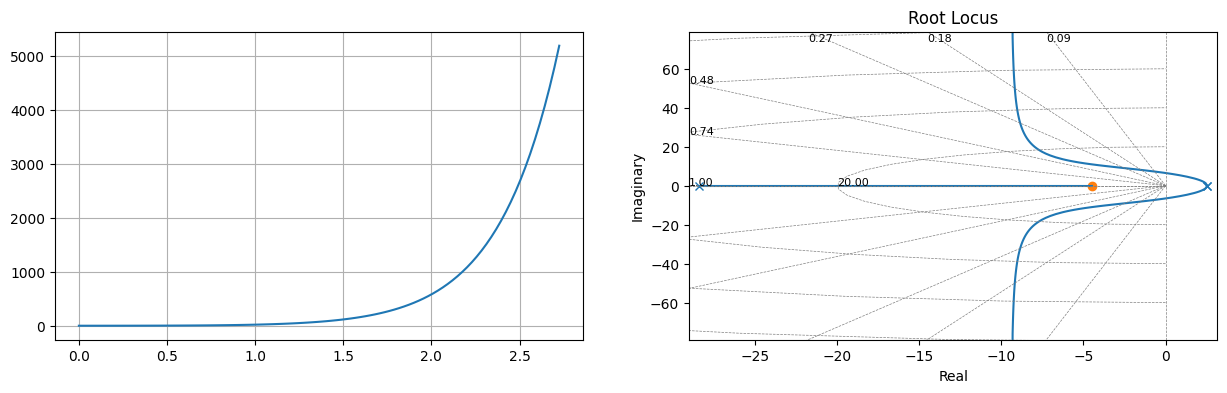

In [75]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [76]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 5181.334737891757,
 'peakTime': 2.7252219002952884,
 'settlingTime': None,
 'finalValue': 5181.334737891757,
 'error': 5180.334737891757}

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [77]:
s = ctl.TransferFunction.s

In [78]:
def getResponsePID(Kp, Ti, Td):
    C     = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_ma = G*C

    error = 1/(1 + G_ma(0.00001))

    if error > 0.1:
        return None

    time, response = ctl.step_response(ctl.feedback(G_ma, 1), T=np.linspace(0, 20, 100))
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

In [79]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 10, 10)
Td_data = np.linspace(0.01, 10, 10)

In [80]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

In [81]:
df = pd.DataFrame(data)
df

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.673235,1.673234,0.202020,4.040404,1.000000,1.928965e-07,11.12,1.12,0.01
1,0.132078,1.132074,0.202020,4.444444,0.999996,3.616447e-06,11.12,1.12,1.12
2,0.159942,1.159868,0.202020,4.848485,0.999936,6.376853e-05,11.12,1.12,2.23
3,0.175070,1.174701,0.202020,4.444444,0.999686,3.140975e-04,11.12,1.12,3.34
4,0.184333,1.183453,0.202020,3.636364,0.999257,7.429095e-04,11.12,1.12,4.45
...,...,...,...,...,...,...,...,...,...
805,0.004301,0.999996,0.606061,0.404040,0.995714,4.286378e-03,100.00,10.00,5.56
806,0.004412,0.999922,0.606061,0.404040,0.995529,4.471024e-03,100.00,10.00,6.67
807,0.004465,0.999870,0.606061,0.404040,0.995426,4.574194e-03,100.00,10.00,7.78
808,0.004467,0.999832,0.606061,0.404040,0.995385,4.614830e-03,100.00,10.00,8.89


### ANÁLISE DOS DADOS

In [82]:
Ts = 50.0
UP = 0.2

In [83]:
target = df.loc[df['settlingTime'] < Ts]
target

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.673235,1.673234,0.202020,4.040404,1.000000,1.928965e-07,11.12,1.12,0.01
1,0.132078,1.132074,0.202020,4.444444,0.999996,3.616447e-06,11.12,1.12,1.12
2,0.159942,1.159868,0.202020,4.848485,0.999936,6.376853e-05,11.12,1.12,2.23
3,0.175070,1.174701,0.202020,4.444444,0.999686,3.140975e-04,11.12,1.12,3.34
4,0.184333,1.183453,0.202020,3.636364,0.999257,7.429095e-04,11.12,1.12,4.45
...,...,...,...,...,...,...,...,...,...
805,0.004301,0.999996,0.606061,0.404040,0.995714,4.286378e-03,100.00,10.00,5.56
806,0.004412,0.999922,0.606061,0.404040,0.995529,4.471024e-03,100.00,10.00,6.67
807,0.004465,0.999870,0.606061,0.404040,0.995426,4.574194e-03,100.00,10.00,7.78
808,0.004467,0.999832,0.606061,0.404040,0.995385,4.614830e-03,100.00,10.00,8.89


In [84]:
target = target.loc[target['overshoot'] == target['overshoot'].min()]
target

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
360,0.0,1.000000,20.0,1.414141,1.000000,3.115534e-09,55.56,1.12,0.01
370,0.0,0.999992,20.0,1.818182,0.999992,8.192360e-06,55.56,2.23,0.01
450,0.0,1.000000,20.0,1.212121,1.000000,2.246819e-09,66.67,1.12,0.01
452,0.0,0.999995,20.0,0.404040,0.999995,5.388626e-06,66.67,1.12,2.23
453,0.0,0.999959,20.0,0.404040,0.999959,4.102758e-05,66.67,1.12,3.34
454,0.0,0.999890,20.0,0.404040,0.999890,1.103575e-04,66.67,1.12,4.45
455,0.0,0.999807,20.0,0.404040,0.999807,1.925354e-04,66.67,1.12,5.56
456,0.0,0.999729,20.0,0.404040,0.999729,2.710695e-04,66.67,1.12,6.67
457,0.0,0.999661,20.0,0.606061,0.999661,3.385981e-04,66.67,1.12,7.78
458,0.0,0.999607,20.0,0.606061,0.999607,3.933633e-04,66.67,1.12,8.89


In [85]:
target = target.loc[target['error'] == target['error'].min()]
target

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
450,0.0,1.0,20.0,1.212121,1.0,2.246819e-09,66.67,1.12,0.01


In [86]:
row = target.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(66.67, 1.12, 0.01)

# RESPOSTA CONTROLADA

In [87]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
print(sympyFunction(C))
C

(0.746704*s**2 + 75.3371*s + 66.67)/(0.00112*s**2 + 1.12*s)


TransferFunction(array([ 0.746704, 75.3371  , 66.67    ]), array([0.00112, 1.12   , 0.     ]))

In [88]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([ 0.09666643, 10.18841546, 52.5660215 , 38.8806106 ]), array([ 6.13460188e-06,  6.27777725e-03,  1.42331186e-01, -8.43066504e-01,
        1.12000000e+00,  0.00000000e+00]))

In [89]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([ 0.09666643, 10.18841546, 52.5660215 , 38.8806106 ]), array([6.13460188e-06, 6.27777725e-03, 2.38997619e-01, 9.34534896e+00,
       5.36860215e+01, 3.88806106e+01]))

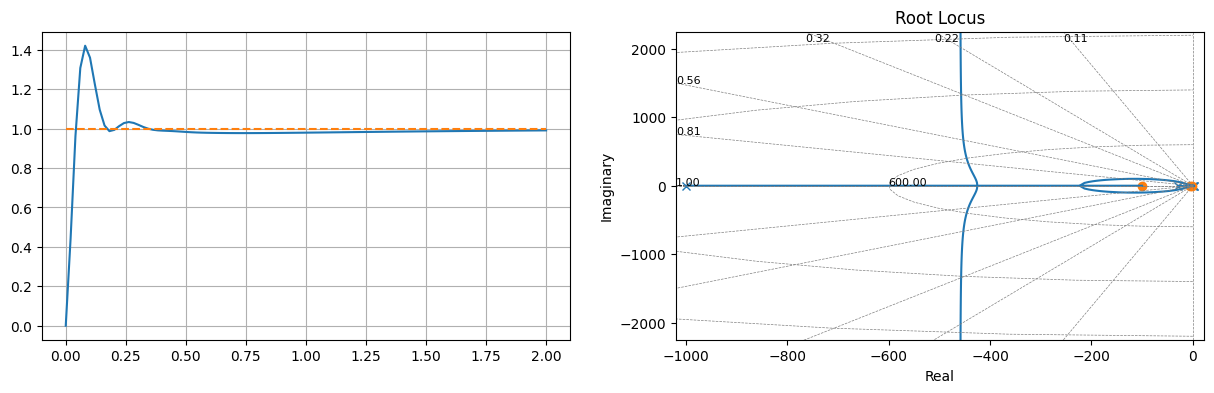

In [90]:
time, response = ctl.step_response(G_feedback, T=np.linspace(0, 2, 100))
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [91]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.4335062386929771
valor de pico:  1.4202269475938512
tempo de pico:  0.08080808080808081
tempo de assentamento:  0.3434343434343435
valor final:  0.9907364957747002
erro:  0.009263504225299757


# APLICANDO VÁRIOS STEPS

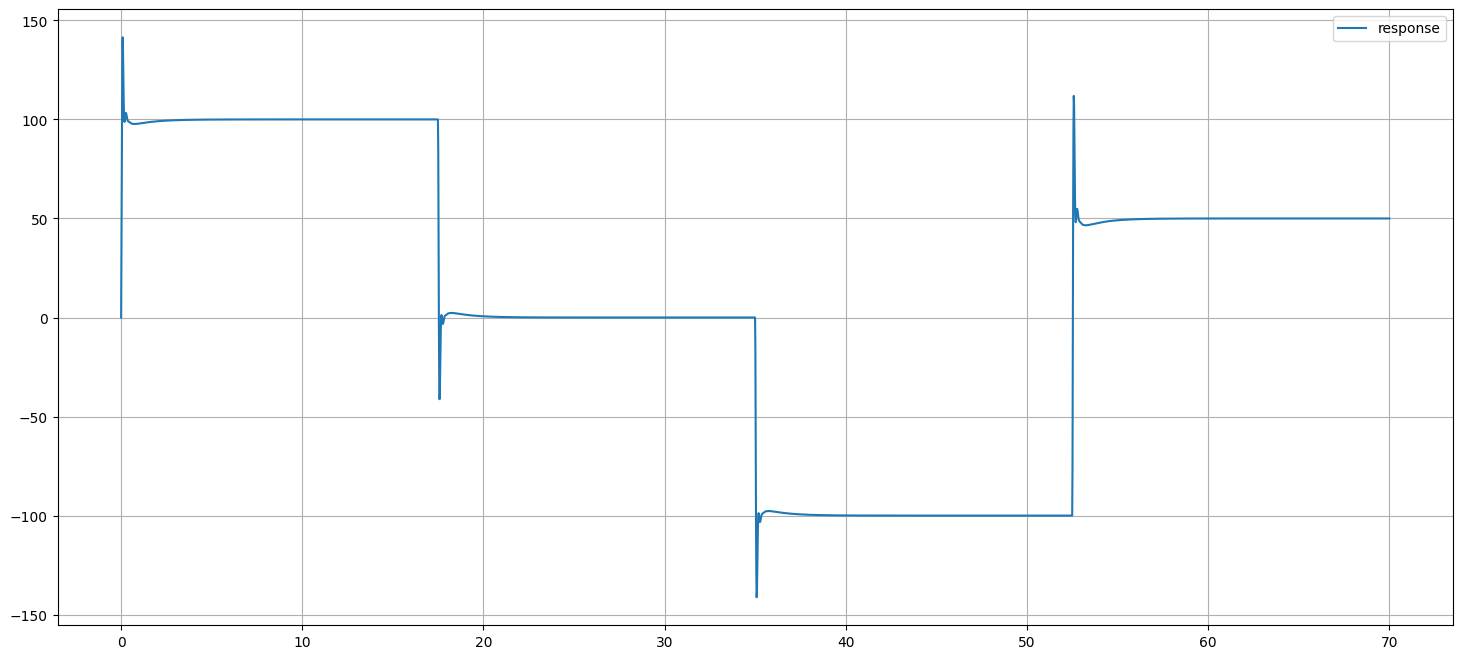

In [92]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 70, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()